# Hierarchical AI Agents System

This notebook demonstrates a sophisticated hierarchical agent system using LangGraph, featuring:

1. **Research Team**: Coordinates web search and scraping agents
2. **Writing Team**: Manages document creation, editing, and chart generation 
3. **Super Team**: High-level coordinator managing both research and writing teams

## Architecture Overview

The system uses a three-tier hierarchy:
- **Super Supervisor**: Routes between research and writing teams
- **Team Supervisors**: Coordinate individual agents within each team
- **Individual Agents**: Specialized workers for specific tasks

## Key Features

- Multi-agent coordination using LangGraph
- Hierarchical task delegation
- Specialized tools for research, writing, and visualization
- Automatic workflow management with supervisor patterns

In [2]:
import os
from dotenv import load_dotenv
from pydantic import SecretStr

load_dotenv()

openai_api_key = SecretStr(os.getenv("OPENAI_API_KEY"))
tavily_api_key = SecretStr(os.getenv("TAVILY_API_KEY"))
groq_api_key = SecretStr(os.getenv("GROQ_API_KEY"))

## 1. Environment Configuration

Setting up API keys and environment variables for the hierarchical agent system.

In [ ]:
# Set USER_AGENT environment variable for web requests
# This is required for web scraping to identify our application
os.environ["USER_AGENT"] = "HierarchicalAgents/1.0"

In [4]:
from typing import Annotated, List
from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily = TavilySearch(max_results=3, api_key=tavily_api_key)

@tool
def scrap_web(urls: List[str]) -> str:
    """Scrape the content of a webpage given its URL."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [f"Document name: {doc.metadata.get('title', '')}\n{doc.page_content}" for doc in docs]
    )

## 2. Core Tools and Utilities

Defining specialized tools that will be used by different agents in the hierarchy.

### 2.1 Research Tools

Tools for web search and content scraping used by the research team.

In [5]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional, TypedDict

from langchain_experimental.utilities import PythonREPL

_temp_dir = TemporaryDirectory()
working_dir = Path(_temp_dir.name)

@tool
def create_outline(
    points: Annotated[List[str], "List of main points for the outline"],
    file_name: Annotated[str, "The name of the file to save the outline"],
) -> Annotated[str, "The file path where the outline is saved"]:
    """Create a text file with the given outline points."""
    with (working_dir / file_name).open("w") as f:
        for i, point in enumerate(points):
            f.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {working_dir / file_name}"

@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (working_dir / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (working_dir / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (working_dir / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (working_dir / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

repl = PythonREPL()

@tool
def python_repl_tool(code: Annotated[str, "Python code to execute"]) -> str:
    """Execute Python code in a REPL environment."""
    try:
        results = repl.run(code)
    except BaseException as e:
        return f"Failed to execute code: {repr(e)}"
    return results


### 2.2 Document Management Tools

Tools for creating, reading, editing documents and executing Python code.

In [6]:
from typing import List, Optional, Any, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

class State(MessagesState):
    next: str

def make_supervisor_node(llm: BaseChatModel, members: List[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )
    class Router(TypedDict):
        """Worker to route to next, If no worker is needed, return FINISH."""
        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-powered supervisor that routes to the next worker or ends the process."""
        messages = [
            {"role": "system", "content": system_prompt,}
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END
        return Command(goto=goto, update={"next": goto})
    return supervisor_node

## 3. Supervisor Framework

Core framework for creating supervisor nodes that coordinate multiple agents.

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_groq import ChatGroq

# Initialize the main LLM for all agents
# Using Groq for faster inference, can be switched to OpenAI if needed
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0, api_key=groq_api_key)
# Alternative: llm = ChatOpenAI(model="gpt-4", temperature=0, api_key=openai_api_key)

# Create research agents
search_agent = create_react_agent(llm, tools=[tavily])
web_scraper_agent = create_react_agent(llm, tools=[scrap_web])

def search_node(state: State) -> Command[Literal["supervisor"]]:
    """Node for handling web search requests."""
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        goto="supervisor",
    )

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    """Node for handling web scraping requests."""
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        goto="supervisor",
    )

# Create research team supervisor
research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

## 4. Research Team Configuration

Setting up the research team with search and web scraping capabilities.

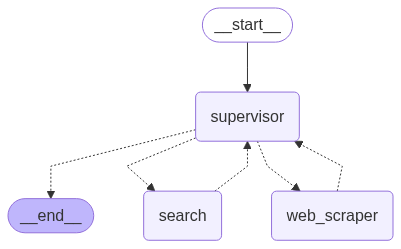

In [20]:
# Build the research team graph
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

# Set up the workflow - always start with supervisor
research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

# Visualize the research team graph
from IPython.display import Image, display
display(Image(research_graph.get_graph().draw_mermaid_png()))

### 4.1 Research Team Graph Construction

Building the research team workflow graph and testing it.

In [21]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Taylor Swift\'s next tour is reportedly scheduled to start in 2027, following the release of her 12th studio album, "The Life of a Showgirl," on October 3. The tour will be a follow-up to the record-breaking Eras Tour. However, the exact start date and ticket prices have not been officially announced by Swift, and the timeline for her next tour remains speculative.', additional_kwargs={}, response_metadata={}, name='search', id='28c417f7-244e-4e31-93eb-0bc7761ab704')]}}
---
{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Based on the search results, it appears that Taylor Swift\'s next tour is scheduled to start in 2027, following the release of her 12th studio album, "The Life of a Showgirl," on October 3. However, the exact start date and ticket prices have not been officially announced by Swift, and the timeline for her next tour remains speculative.\n\nIt\'s w

### 4.2 Research Team Testing

Testing the research team with a sample query.

## 5. Document Writing Team Configuration

Setting up the writing team with document creation, editing, and chart generation capabilities.

In [ ]:
# Create document writing team agents using the same LLM instance
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)

note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)

chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)

def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    """Node for handling document writing tasks."""
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        goto="supervisor",
    )

def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    """Node for handling note-taking and outline creation."""
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        goto="supervisor",
    )

def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    """Node for handling chart and visualization generation."""
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        goto="supervisor",
    )

# Create document writing team supervisor
doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

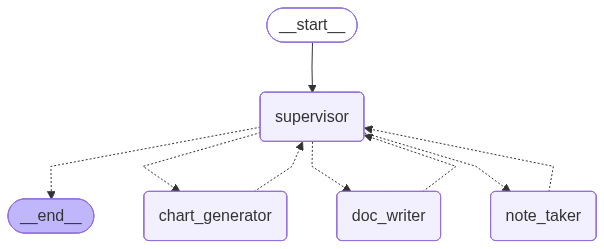

In [24]:
# Build the document writing team graph
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

# Set up the workflow - always start with supervisor
paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

# Visualize the writing team graph
from IPython.display import Image, display
display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

### 5.1 Document Writing Team Graph Construction

Building the writing team workflow graph.

## 6. Hierarchical Super Team Configuration

Creating the top-level supervisor that coordinates between research and writing teams.

In [ ]:
from langchain_core.messages import BaseMessage

# Create the top-level team supervisor that coordinates between research and writing teams
team_supervisor_node = make_supervisor_node(
    llm, ["research_team", "writer_team"]
)

In [ ]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    """Delegate tasks to the research team and return results to super supervisor."""
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [HumanMessage(content=response["messages"][-1].content, name="research_team")]
        },
        goto="supervisor",
    )

def call_writer_team(state: State) -> Command[Literal["supervisor"]]:
    """Delegate tasks to the writing team and return results to super supervisor."""
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [HumanMessage(content=response["messages"][-1].content, name="writer_team")]
        },
        goto="supervisor",
    )

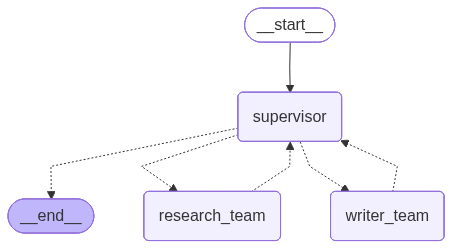

In [34]:
# Build the complete hierarchical system graph
super_builder = StateGraph(State)
super_builder.add_node("supervisor", team_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writer_team", call_writer_team)

# Set up the workflow - always start with the super supervisor
super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

# Visualize the complete hierarchical system
from IPython.display import Image, display
display(Image(super_graph.get_graph().draw_mermaid_png()))

## 8. Summary and Next Steps

### What We Built

This notebook demonstrates a sophisticated three-tier hierarchical agent system:

1. **Super Supervisor**: Routes high-level tasks between research and writing teams
2. **Team Supervisors**: Coordinate specialized agents within each team
3. **Individual Agents**: Execute specific tasks like web search, scraping, document writing, etc.

### Key Benefits

- **Modularity**: Each team can be developed and tested independently
- **Scalability**: Easy to add new teams or agents to the hierarchy
- **Flexibility**: Tasks are automatically routed to the most appropriate team
- **Robustness**: Each level of supervision ensures tasks are completed properly

### Potential Improvements

- Add error handling and retry mechanisms
- Implement memory persistence across sessions
- Add more specialized tools for specific domains
- Create a web interface for easier interaction
- Add logging and monitoring capabilities

### Usage Examples

The system can handle complex tasks that require multiple capabilities:
- Research and report generation (as demonstrated)
- Data analysis with visualization
- Content creation with fact-checking
- Multi-step problem solving requiring different skill sets

## 7. System Execution and Testing

Running the complete hierarchical agent system with a complex task that requires both research and writing capabilities.